In [1]:
import pandas as pd
import numpy as np
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

In [2]:
df = pd.read_csv(r"C:\Users\Robyi\Documents\Data Science Dataset\retail.csv", encoding='ISO-8859-1')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
df = df[~df['InvoiceNo'].astype(str).str.contains('C')]
df = df.dropna(subset=['Description']) 

transactions = df.groupby(['InvoiceNo'])['Description'].apply(list).reset_index(name='Items')

te = TransactionEncoder()
te_ary = te.fit(transactions['Items']).transform(transactions['Items'])
encoded_df = pd.DataFrame(te_ary, columns=te.columns_)

In [7]:
frequent_itemsets = apriori(
    encoded_df, 
    min_support=0.02,  
    use_colnames=True,
    low_memory=True,   
    max_len=4          
).sort_values(by='support', ascending=False)

rules = association_rules(
    frequent_itemsets, 
    metric="confidence",
    min_threshold=0.4,
     num_itemsets=len(frequent_itemsets)
).sort_values(by='lift', ascending=False)

rules['leverage'] = rules['support'] - (rules['antecedent support'] * rules['consequent support'])
rules['conviction'] = (1 - rules['antecedent support']) / (1 - rules['confidence'])

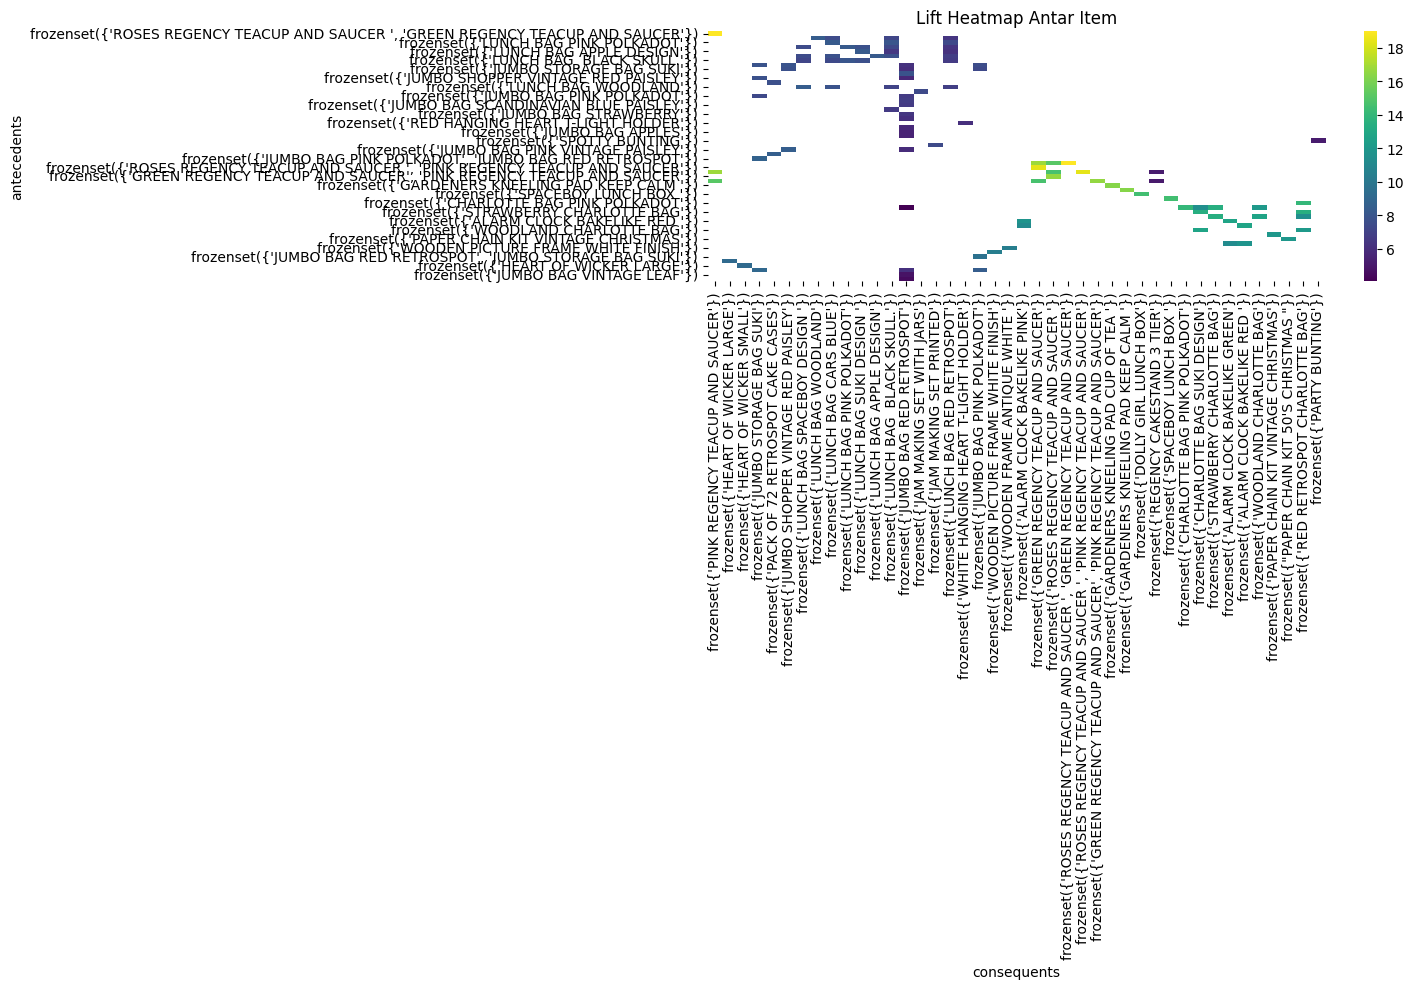

In [8]:
plt.figure(figsize=(15,10))

sns.heatmap(
    pd.pivot_table(
        rules, 
        index='antecedents', 
        columns='consequents', 
        values='lift'
    ),
    cmap='viridis'
)
plt.title('Lift Heatmap Antar Item')
plt.tight_layout()
plt.show()

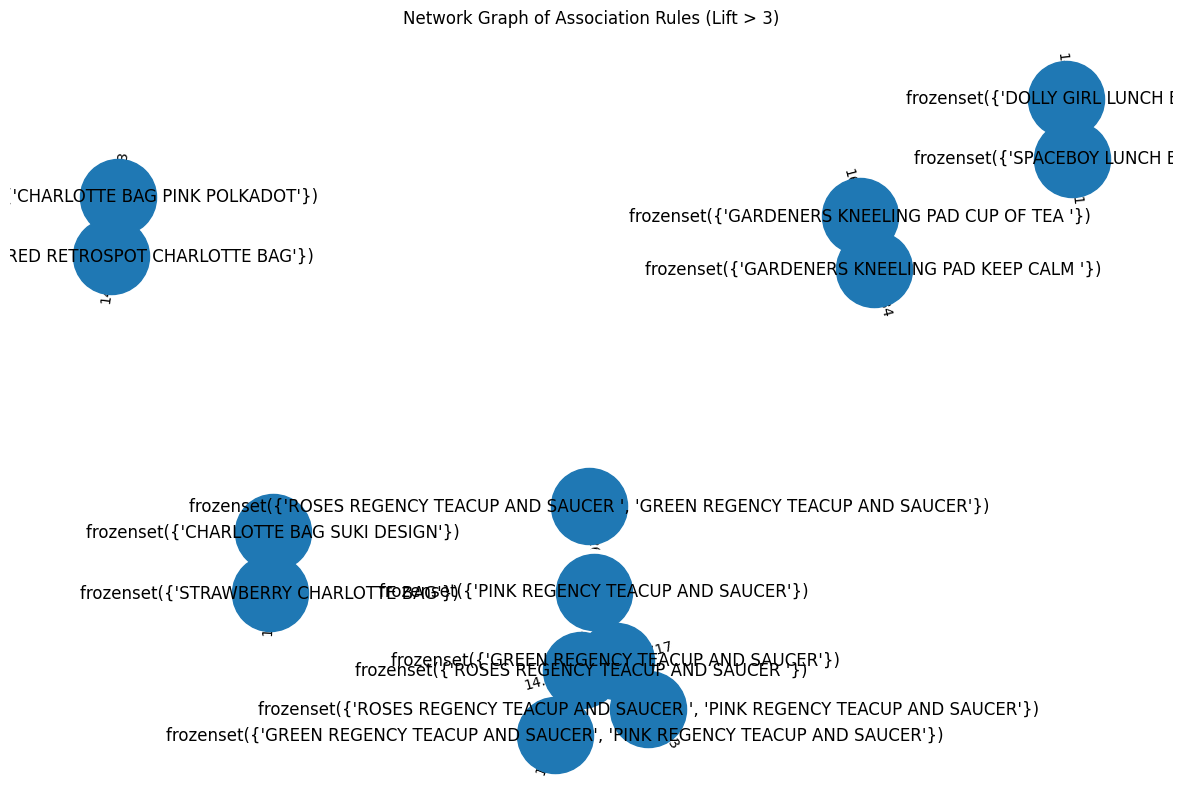

In [9]:
fig, ax = plt.subplots(figsize=(15, 10))
GA = nx.from_pandas_edgelist(
    rules[rules['lift'] > 3].head(20),
    source='antecedents',
    target='consequents',
    edge_attr=True
)

pos = nx.spring_layout(GA, k=0.1)
nx.draw(GA, pos, with_labels=True, node_size=3000, font_size=12, ax=ax)
edge_labels = nx.get_edge_attributes(GA, 'lift')
nx.draw_networkx_edge_labels(GA, pos, edge_labels=edge_labels)
plt.title('Network Graph of Association Rules (Lift > 3)')
plt.show()

In [10]:
print("Top 5 Association Rules:")
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head())

Top 5 Association Rules:
                                          antecedents  \
27  (ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...   
28                   (PINK REGENCY TEACUP AND SAUCER)   
25  (ROSES REGENCY TEACUP AND SAUCER , PINK REGENC...   
30                  (GREEN REGENCY TEACUP AND SAUCER)   
9                    (PINK REGENCY TEACUP AND SAUCER)   

                                          consequents   support  confidence  \
27                   (PINK REGENCY TEACUP AND SAUCER)  0.026298    0.705729   
28  (ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...  0.026298    0.707572   
25                  (GREEN REGENCY TEACUP AND SAUCER)  0.026298    0.904841   
30  (ROSES REGENCY TEACUP AND SAUCER , PINK REGENC...  0.026298    0.533990   
9                   (GREEN REGENCY TEACUP AND SAUCER)  0.030713    0.826371   

         lift  
27  18.988353  
28  18.988353  
25  18.373184  
30  18.373184  
9   16.779804  
